In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import tensorflow as tf

from tqdm import tqdm

import keras
from keras.initializers import Constant

!pip install np_utils
from keras.utils import np_utils


from keras.layers.embeddings import Embedding
from keras.preprocessing import text, sequence


# Import Plotting Libararies
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix
!pip install gensim
import gensim


     |████████████████████████████████| 61 kB 3.5 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=7a58a2705bf97da58740958c6dfcc397cfa8cfe949f088d123551f7f1da52cbb
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


In [ ]:

# Load Google's pre-trained Word2Vec model.
#model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/nlp/GoogleNews-vectors-negative300.bin', binary=True)  

In [ ]:
data = pd.read_csv("/content/drive/My Drive/nlp/Sarcasm Dataset.csv")

In [ ]:
#data = data.dropna()

data = data[['tweet', 'sarcastic']]


X = data['tweet'].fillna("")
Y = data["sarcastic"]
data.shape

(3468, 2)

In [ ]:
data.head(10)

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
5,"@jimrossignol I choose to interpret it as ""XD""...",1
6,Why would Alexa's recipe for Yorkshire pudding...,1
7,someone hit me w a horse tranquilizer istg ive...,1
8,Loving season 4 of trump does America. Funnies...,1
9,Holly Arnold ??? Who #ImACeleb #MBE nope not ...,1


In [ ]:
# We'll write a function which will clean the text and prepare it.
def cleanText(text):
    cleaned = re.sub("[^a-zA-Z0-9']"," ",text)
    lowered = cleaned.lower()
    return lowered.strip()

cleanText("Let's test our function, by writing this string!")

"let's test our function  by writing this string"

In [ ]:

x_cleaned = [cleanText(t) for t in X]
x_cleaned[:4]

['the only thing i got from college is a caffeine addiction',
 'i love it when professors draw a big question mark next to my answer on an exam because i m always like yeah i don t either',
 'remember the hundred emails from companies when covid started getting real  i ve gotten three in regards to support for protests  and only  savagexfenty shared helpful links and actually said black lives matter    we love capitalism',
 'today my pop pop told me i was not  forced  to go to college   okay sure sureeee']

In [ ]:
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in x_cleaned]
x_tokenized[2]

['remember',
 'the',
 'hundred',
 'emails',
 'from',
 'companies',
 'when',
 'covid',
 'started',
 'getting',
 'real',
 'i',
 've',
 'gotten',
 'three',
 'in',
 'regards',
 'to',
 'support',
 'for',
 'protests',
 'and',
 'only',
 'savagexfenty',
 'shared',
 'helpful',
 'links',
 'and',
 'actually',
 'said',
 'black',
 'lives',
 'matter',
 'we',
 'love',
 'capitalism']

In [ ]:
len(x_tokenized)


3468

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = "/content/drive/My Drive/nlp/glove.6B.50d.txt.word2vec"
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)


King:  [ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]
Most similar word to King + Woman:  [('queen', 0.8523603677749634)]


In [ ]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = str(sentence).split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data["tweet"],data["sarcastic"],test_size=0.3,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2427,)
(1041,)
(2427,)
(1041,)


In [ ]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(x_train)

# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(x_test)


Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 55 / 2427
Numer of samples with no words found: 20 / 1041


In [ ]:
print(Xtrain.shape,Xtest.shape)


(2427, 50) (1041, 50)


In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(Xtrain, y_train)

print("train score:", svm_classifier.score(Xtrain, y_train))
print("test score:", svm_classifier.score(Xtest, y_test))

train score: 0.7606098063452822
test score: 0.7252641690682037


In [ ]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.72526   1.00000   0.84076       755
           1    0.00000   0.00000   0.00000       286

    accuracy                        0.72526      1041
   macro avg    0.36263   0.50000   0.42038      1041
weighted avg    0.52601   0.72526   0.60977      1041

<function confusion_matrix at 0x7f39c38fc200>


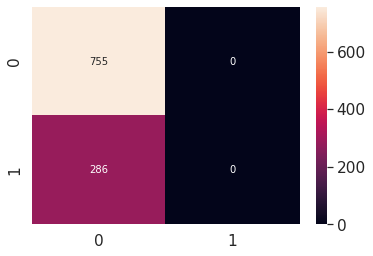

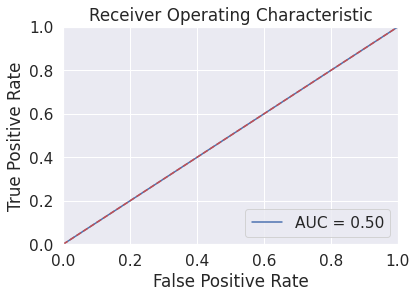

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sn

# Predicting the Test set results
y_pred =svm_classifier.predict(Xtest)

print(metrics.classification_report(y_test, y_pred,  digits=5))
confusion_matrix(y_test, y_pred,)
print(confusion_matrix)
plot_confussion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred)